In [1]:
"""
One brick in the hierachy for an industrial ethylene-oxide reactor

© 2023. Triad National Security, LLC. All rights reserved.
This program was produced under U.S. Government contract 89233218CNA000001 for Los Alamos
National Laboratory (LANL), which is operated by Triad National Security, LLC for the U.S.
Department of Energy/National Nuclear Security Administration. All rights in the program are.
reserved by Triad National Security, LLC, and the U.S. Department of Energy/National Nuclear
Security Administration. The Government is granted for itself and others acting on its behalf a
nonexclusive, paid-up, irrevocable worldwide license in this material to reproduce, prepare.
derivative works, distribute copies to the public, perform publicly and display publicly, and to permit.
others to do so.

@author: Sean T. Smith, Oct. 2022
"""

from numpy import array, empty, ones, linspace, arange, cumsum, cumprod, interp, sqrt, exp
from numpy.linalg import solve
from scipy.special import erf

%matplotlib inline
import matplotlib.pyplot as plt

$$\require{mhchem}$$
# BET Theory
Brunauer–Emmett–Teller (BET) theory ([wikipedia](https://en.wikipedia.org/wiki/BET_theory)) is an extension of Langmuir theory ([wikipedia](https://en.wikipedia.org/wiki/Langmuir_equation)). Specifically it aims to extend adsorption beyond a mono-layer (to which Langmuir's theory limits itself). Over time, it has been so instrumental in the determination of  catalyst surface area (and other heterogeneous materials) that it has become synonymous with a specific experimental procedure. [Here](references/BET-IITKampur-Slides.pdf) are slides giving a modern overview of concepts and issues from a technical perspective.  
## Concepts
The primary conceptual modeling abstraction is that multiple layers of adsorbed molecules are tracked by the size of each column (perpendicular from the surface). The model accounts for the equilibrium for all columns of equal height in the same way Langmuir models its mono-layer.
\begin{equation} \begin{split}
\ce{A_{(g)} + S^{\star} &<=>[K_1] A_{1(s)}} \\
\ce{A_{(g)} + A_{1(s)} &<=>[K_2] A_{2(s)}} \\
\ce{A_{(g)} + A_{2(s)} &<=>[K_3] A_{3(s)}} \\
& \vdots \\
\ce{A_{(g)} + A_{n-1(s)} &<=>[K_n] A_{n(s)}}
\end{split} \end{equation}
In theory, $n$ is large — taking the $\lim_{n \rightarrow \infty}$. (In practice $10 < n < 15$ is sufficient at low relative pressures.) Quasi-steady conditions result in the following behavior:
\begin{equation} \begin{split}
K_1 &= \tfrac{\ce{[A_{1(s)}]}}{\ce{[A_{(g)}][S^{\star}]}} \quad &= \tfrac{\phi_1}{P_A \phi_S} ,\\
K_2 &= \tfrac{\ce{[A_{2(s)}]}}{\ce{[A_{(g)}][A_{1(s)}]}} \quad &= \tfrac{\phi_2}{P_A \phi_1} ,\\
K_3 &= \tfrac{\ce{[A_{3(s)}]}}{\ce{[A_{(g)}][A_{2(s)}]}} \quad &= \tfrac{\phi_3}{P_A \phi_2} ,\\
&\vdots &\vdots \\
K_n &= \tfrac{\ce{[A_{n(s)}]}}{\ce{[A_{(g)}][A_{n-1(s)}]}} \quad &= \tfrac{\phi_n}{P_A \phi_{n-1}} .
\end{split} \end{equation}
Here, $\phi_i$ refers to the fractional coverage of sites with exactly $i$ molecules in its column, and $\phi_S$ refers to the fractional number of free sites.

As a side note, there are a few effects associated with these equilibrium constants worth being aware of. When the adsorption is associated with a phase change only it is called **Physisorption** and it exhibits this multi-layer behavior. When the adsorption is associated with a chemical reaction to the surface it is called **Chemisorption** and only exhibits a mono-layer (meaning $K_n = 0$ for $n \ge 2$). For physisorption the temperature dependence of the equilibrium is relatively constant ($E_{\mathrm{a}} \approxeq 0$ — non-zero, but small), while chemisorption usually exhibits $60 \le E_{\mathrm{a}} \le 100~\tfrac{\mathrm{kJ}}{\mathrm{mol}}$. Also for chemisorption, steric hindrance occurs when a pore is filled with adsorbate or even when a necking blockage occurs along the length of the pore. 

## Model Development
Another of the primary assumptions of BET theory is that the equilibrium constants for all the deeper layers are nearly equal to the vapor-liquid equilibrium. That is
\begin{equation}
K_2 \approxeq K_3 \approxeq \cdots \approxeq K_n = 1/P^{\mathrm{sat.}}.
\end{equation}
In reality, $K_2$ is often between $K_1$ and $K_n$ and there is an exponential decay to the vapor-liquid equilibrium. Also, steric hindrance in the pores can be modeled as setting $K_i = 0$ for all sufficiently large $i$. But the equality approximation is convenient enough to be in common use. It does allow significant simplification.
\begin{equation}
\phi_i \approxeq K_1 P_A \phi_S \left( \tfrac{P_A}{P^{\mathrm{sat.}}} \right)^{i-1}.
\end{equation}
Now we can solve for $\phi_S$ in terms of the known pressures, $P_A$ and $P^{\mathrm{sat.}}$, and in terms of the unknown mono-layer equilibrium constant, $K_1$:
\begin{equation} \begin{split}
\phi_S &= 1 - (\phi_1 + \phi_2 + \dots + \phi_n)  = 1 - \sum_{j=1}^n \phi_j = 1 - \sum_{j=1}^n K_1 P_A \phi_S \left( \tfrac{P_A}{P^{\mathrm{sat.}}} \right)^{j-1} \\
&= 1 - K_1 P_A \phi_S \left[ 1 + \left( \tfrac{P_A}{P^{\mathrm{sat.}}} \right) + \left( \tfrac{P_A}{P^{\mathrm{sat.}}} \right)^2 + \left( \tfrac{P_A}{P^{\mathrm{sat.}}} \right)^3 + \dots + \left( \tfrac{P_A}{P^{\mathrm{sat.}}} \right)^{n-1} \right] \quad \text{(which is a well know Taylor series)} \\
&= 1 - K_1 P_A \phi_S \big/ \left[ 1 - \left( \tfrac{P_A}{P^{\mathrm{sat.}}} \right) \right]  \quad \text{and solving for $\phi_S$...} \\
& \left[ 1 + \frac{K_1 P_A}{1 - \tfrac{P_A}{P^{\mathrm{sat.}}}} \right] \phi_S = 1, \quad \Rightarrow \quad \phi_S = \frac{1}{1 + \tfrac{K_1 P_A}{1 - \tfrac{P_A}{P^{\mathrm{sat.}}}}} = \frac{1 - \tfrac{P_A}{P^{\mathrm{sat.}}}}{1 - \tfrac{P_A}{P^{\mathrm{sat.}}} + K_1 P_A} . \\
\end{split} \end{equation}
Similarly we can solve for the total number of molecules adsorbed:
\begin{equation} \begin{split}
n_{\mathrm{ad.}} &= n^{\star} \left[ \phi_1 + 2 \phi_2 + 3 \phi_3 + \dots + n \phi_n \right] \quad \text{...where $n^{\star}$ is the total number of sites} \\
&= n^{\star} \left[ K_1 P_A \phi_S + 2 K_1 P_A \phi_S \left( \tfrac{P_A}{P^{\mathrm{sat.}}} \right) + 3 K_1 P_A \phi_S \left( \tfrac{P_A}{P^{\mathrm{sat.}}} \right)^2 + \dots + n K_1 P_A \phi_S \left( \tfrac{P_A}{P^{\mathrm{sat.}}} \right)^{n-1} \right] \\
&= n^{\star} K_1 P_A \phi_S \left[ 1 + 2 \left( \tfrac{P_A}{P^{\mathrm{sat.}}} \right) + 3 \left( \tfrac{P_A}{P^{\mathrm{sat.}}} \right)^2 + \dots + n \left( \tfrac{P_A}{P^{\mathrm{sat.}}} \right)^{n-1} \right] \quad \text{(which is another well know Taylor series...)} \\
&= n^{\star} K_1 P_A \phi_S \big/ \left( 1 - \tfrac{P_A}{P^{\mathrm{sat.}}} \right)^2 \quad \text{and substituting $\phi_S$...} \\
&= n^{\star} K_1 P_A \frac{1 - \tfrac{P_A}{P^{\mathrm{sat.}}}}{\left( 1 - \tfrac{P_A}{P^{\mathrm{sat.}}} + K_1 P_A \right) \left( 1 - \tfrac{P_A}{P^{\mathrm{sat.}}} \right)^2} \\
&= \frac{n^{\star} K_1 P_A}{\left( 1 - \tfrac{P_A}{P^{\mathrm{sat.}}} + K_1 P_A \right) \left( 1 - \tfrac{P_A}{P^{\mathrm{sat.}}} \right)} \quad \text{if we let $C \equiv K_1 / K_n$, then $K_1 = C / P^{\mathrm{sat.}}$ and...} \\
&= \frac{n^{\star} C \tfrac{P_A}{P^{\mathrm{sat.}}}}{\left( 1 + [C - 1] \tfrac{P_A}{P^{\mathrm{sat.}}} \right) \left( 1 - \tfrac{P_A}{P^{\mathrm{sat.}}} \right)} .
\end{split} \end{equation}

## Experimental Setup
At this juncture, the BET theory moves to infer the unknowns in these equations from experimental data — in practice the experimental data, the theory, and the inference are all unified into one concept. Before the equations reflecting that mash-up are shown, let's address the experimental procedure and issues to be aware of.  
- First, it is important to minimize any adsorbed gas or oils on the catalyst sample prior to the experiment. This often requires heating the sample while in a vacuum environment and waiting sufficient time for degassing.
- The experiment is going to be performed usually with $\ce{N_2}$ or $\ce{Ar}$ at very low temperature, so they have opportunity to condense onto the surface.
- The adsorbate pressure starts low and increases in steps.
- Often only initial solid mass, pressure and temperature are measured (the theory requires a measurement of adsorbed amount of gas, but this can be determined from an additional pressure measurement).
- Most analyses neglect heat of adsorption, but it can be a real issue.
- The adsorbate gas is added in steps starting at a pressure around $P_A/P^{\mathrm{sat.}} = 0.3$ — with each step the pressure is recorded immediately after adding (or an added amount can be measured by alternate means) and recorded again after adsorption reaches steady state. The system should be controlled for isothermal conditions. At least two steps are required to determine surface area, but additional values inform the regression.
- To to determine pore volume and pore radius, an additional measurement should be made near saturation conditions.


## Tying it All Together
With theoretical values for $P^{\mathrm{sat.}}$ and experimental values for $P_A$ & $n_{\mathrm{ad.}}$, the model for $n_{\mathrm{ad.}}$ can be rearranged by known and unknown terms into a linear form (common in chemistry):
\begin{equation}
\tfrac{1}{n_{\mathrm{ad.}} \left( \tfrac{P_{\mathrm{sat.}}}{P_A} - 1 \right)} = \frac{1}{n^{\star}C} + \frac{C - 1}{n^{\star}C} \left( \frac{P_A}{P^{\mathrm{sat.}}} \right).
\end{equation}
Everything on the left-hand side and everything in the parentheses on the right-hand side are known or specified by the experiment at each step, while the intercept and slope can be determined by regressing across multiple steps.
\begin{equation}
\begin{split}
b &\equiv \frac{1}{n^{\star}C}, \\
m &\equiv \frac{C - 1}{n^{\star}C} .
\end{split}
\qquad \Rightarrow \qquad
\begin{split}
C &= \frac{m}{b} + 1, \\
n^{\mathrm{\star}} &= \frac{1}{Cb} .
\end{split}
\end{equation}
If we additionally assume that the area of each site on the catalyst is much smaller than the adsorbate's known cross-sectional area, $A_{\mathrm{cs}}$ in area per mole, (continuum approximation for the surface), then we can finally calculate the surface area of the catalyst.
\begin{equation}
A_{\mathrm{surf}} = n^{\star} N_{\mathrm{A}} A_{\mathrm{cs}} ,
\end{equation}
where $N_{\mathrm{A}}$ is Avagadro's number.
Additionally the pore volume and radius are:
\begin{equation}
V_{\mathrm{pore}} = n_{\mathrm{ad.}} \hat{V}_{\mathrm{liq.}}
\end{equation}
(where $n_{\mathrm{ad.}}$ is measured near saturation conditions and  $\hat{V}_{\mathrm{liq.}}$ is the molar volume of the liquid), and
\begin{equation}
r_{\mathrm{pore}} = \frac{2 V_{\mathrm{pore}}}{A_{\mathrm{surf}}} .
\end{equation}

In [2]:
Na = 6.02214076e23  # Avagadro's number [#/mol]

def antoine(T, A, B, C):
    """
    Calculate the vapor pressure [bar] modeled by the Antoine equation
    as a function of temperaure [K] and parameterized by A, B & C.
    """
    return 10**(A - (B / (T + C)))

In [3]:
# Nitrogen:
# Properties from NIST webbook:
Tc_N2 = 126.192  # critical temp. [K]
Pc_N2 = 3.3958 * 10  # critical pres. [MPa] converted to [bar]
ρc_N2 = 11.1839  # critical dens. [mol/L]
Vml_N2 = 3.484e-5  # molar volume of liquid [m^3/mol]
Acs_N2 = 16.2  # cross-sectional area [Angstrom^2/#]

# Antoine parameters from NIST webbook:
A_N2 = 3.63792
B_N2 = 257.877
C_N2 = -6.344

In [4]:
# Catalyst sample
S_cat = 0.266  # catalyst specific surface area [m^2/g]
m_cat = 100  # mass of catalyst in experiment [g]
σ_cat = min(0.2, 1 / Acs_N2)  # site density on catalyst [#/Angstrom^2]
r_pore = 7_200  # pore radius [Angstroms]
A_cat = S_cat * m_cat  # available surface area [m^2]
n_star = A_cat * σ_cat * 1e20 / Na  # total available number of sites [mol]

# BET Experiment w/ N2:
T_BET = 77  # [K]
V_BET = 1  # [L]
Psat = antoine(T_BET, A_N2, B_N2, C_N2)

In [5]:
# R = 8.314462  # Ideal-gas constant [m^3 Pa / (K mol)]

# def redlich_kwong(T, V, Tc, Pc, Vc):
#     Tr = T / Tc
#     Vr = V / Vc
#     b = 2**(1/3) - 1
#     Pr = 3 * Tr / (Vr - b) - 1 / (b * sqrt(Tr) * Vr * (Vr + b))
#     return Pr * Pc

# n = linspace(1e-3, 0.18, 200)  # [mol]
# V = V_BET / n  # [L/mol]
# Pideal = (n / V_BET) * R * T_BET * 1e-2 / Psat
# P = redlich_kwong(T_BET, V, Tc_N2, Pc_N2, 1 / ρc_N2) / Psat

# plt.plot(n, P, label='RK')
# plt.plot(n, Pideal, label='ideal')
# plt.xlim(0, n[-1])
# plt.ylim(0, 1)
# plt.xlabel('n [mol]', fontsize=16)
# plt.ylabel('P [bar]', fontsize=16)
# plt.legend(fontsize=12) ;

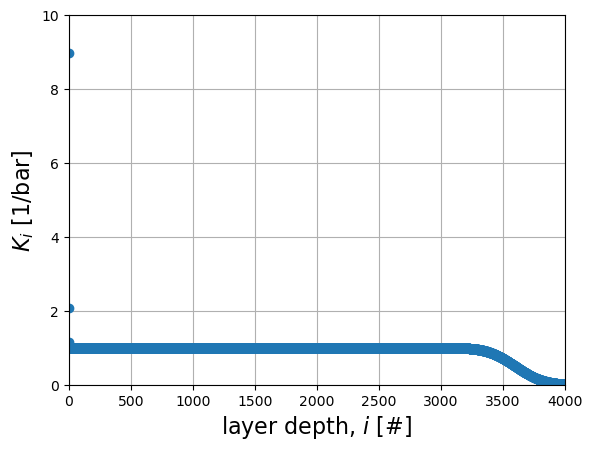

In [6]:
# Specify the Ks:
m_max = 4000
m = arange(1, m_max + 1)
Kn = 1 / Psat
C = 60
K1 = C * Kn
τ = 0.5
n_steric = r_pore / (2 * σ_cat * Acs_N2)
σ_steric = 0.05 * n_steric
Ki = ((K1 - Kn) * exp(-(m - 1) / τ) + Kn) * (erf((n_steric - m) / (sqrt(2) * σ_steric)) + 1) / 2
Ki[0] = K1
plt.plot(m, Ki * Psat, 'o')
plt.xlim(0, m_max + 0.5)
plt.ylim(0, 10)
plt.xlabel('layer depth, $i$ [#]', fontsize=16)
plt.ylabel('$K_i$ [1/bar]', fontsize=16)
plt.grid(True) ;

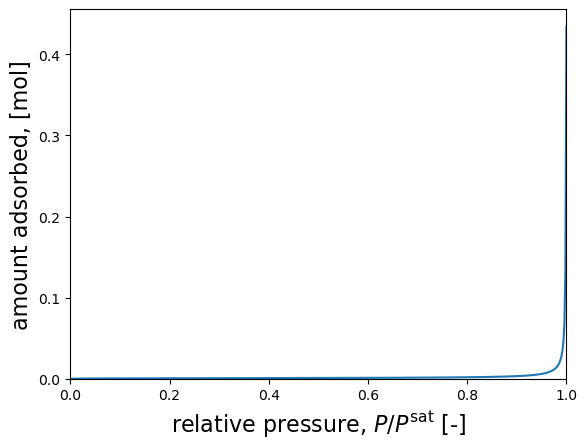

In [7]:
np = 500
Prel = linspace(1e-6, 1 - 1e-8, np)
n_ad = empty(np)
for i in range(np):
    P = Prel[i] * Psat
    Csi = cumprod(Ki * P)
    ϕs = 1 / (1 + Csi.sum())
    ϕi = empty(m_max + 1)
    ϕi[0] = ϕs
    ϕi[1:] = Csi * ϕs
    n_ad[i] = n_star * (m * ϕi[1:]).sum()
plt.plot(Prel, n_ad)
plt.xlim(0, 1)
plt.ylim(0, None)
plt.xlabel('relative pressure, $P/P^{\mathrm{sat}}$ [-]', fontsize=16)
plt.ylabel('amount adsorbed, [mol]', fontsize=16) ;

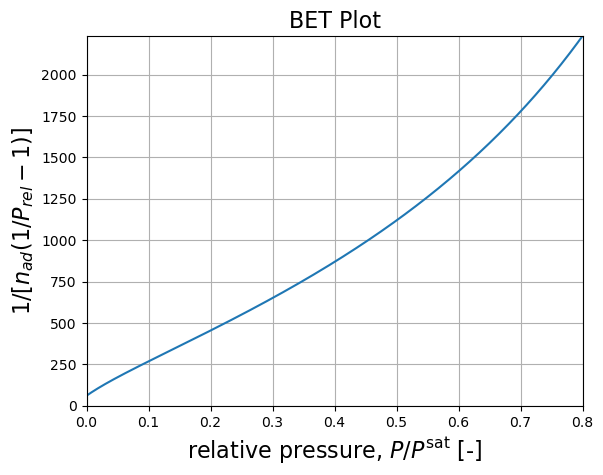

In [8]:
y = 1 / (n_ad * (1 / Prel - 1))
plt.plot(Prel, y)
x_max = 0.8
plt.xlim(0, x_max)
plt.ylim(0, y[Prel < x_max].max())
plt.title('BET Plot', fontsize=16)
plt.xlabel('relative pressure, $P/P^{\mathrm{sat}}$ [-]', fontsize=16)
plt.ylabel('$1/[n_{ad} (1 / P_{rel} - 1)]$', fontsize=16)
plt.grid(True);

In [9]:
# BET Calculation for number of sites & surface area
i0 = 50
i1 = 100
slope = (y[i1] - y[i0]) / (Prel[i1] - Prel[i0])
inter = y[i0] - slope * Prel[i0]
print(y[i0], y[i1])
print(slope, inter)
C = slope / inter + 1
n_star_i = 1 / (C * inter)  # [mol]
print('n* [moles]:')
print(n_star_i)
print(n_star)
print(' ')

A_cat_i = n_star_i * Na * Acs_N2 * 1e-20  # [m^2]
print('Area [m^2]:')
print(A_cat_i)
print(A_cat)
print(' ')

S_cat_i = A_cat_i / m_cat  # [m^2]
print('Spec. Area [m^2/g]:')
print(S_cat_i)
print(S_cat)
print(' ')

V_pore_i = n_ad.max() * Vml_N2  # [m^3]
print('Pore Vol. [m^3]:')
print(V_pore_i)
print((r_pore * 1e-10) * A_cat / 2)
print(' ')

Vs_pore_i = V_pore_i / m_cat  # [m^3]
print('Spec. Pore Vol. [m^3/g]:')
print(Vs_pore_i)
print((r_pore * 1e-10) * A_cat / (2 * m_cat))
print(' ')

r_pore_i = (2 * V_pore_i / A_cat_i) * 1e10  # [Angstrom]
print('Pore Radius [Angstrom]:')
print(r_pore_i)
print(r_pore)

268.7505682841913 455.3042443848794
1861.807567910511 82.19503037593526
n* [moles]:
0.0005144026046474715
0.0002726564147334835
 
Area [m^2]:
50.18443925846278
26.6
 
Spec. Area [m^2/g]:
0.5018443925846278
0.266
 
Pore Vol. [m^3]:
1.5122111074248818e-05
9.576000000000001e-06
 
Spec. Pore Vol. [m^3/g]:
1.5122111074248817e-07
9.576e-08
 
Pore Radius [Angstrom]:
6026.613547026422
7200


In [10]:
adsorbate_thermo = dict(
    nitrogen=dict(Vml=34.84e-6,  # molar volume of liquid [m^3/mol]
                  Acs=16.2,  # cross-sectional area [Angstrom^2/#]
                  crit=dict(T=126.192,  # critical temp. [K]
                            P=(3.3958 * 10),  # critical pres. [MPa] converted to [bar]
                            ρ=11.1839),  # critical density [mol/L]
                  antoine=dict(A=3.63792,
                               B=257.877,
                               C=-6.344)),
    argon=dict(Vml=28.66e-6,  # molar volume of liquid [m^3/mol]
               Acs=14.2,  # cross-sectional area [Angstrom^2/#]
               crit=dict(T=150.86,  # critical temp. [K]
                         P=48.9805,  # critical pres. [bar]
                         ρ=13.41),  # critical density [mol/L]
               antoine=dict(A=3.29555,
                            B=215.24,
                            C=-22.233)))

cat_props = dict(
    klugherz=dict(S_cat = 0.266,  # catalyst specific surface area [m^2/g]
                  σ_cat = 0.2,  # site density on catalyst [#/Angstrom^2]
                  r_pore = 7_200))  # pore radius [Angstroms]

In [11]:
def _BETexpt(cat, m_cat, adsorbate, Texpt, Vexpt, Prels):
    """
    Simulate the performace of a BET experiment.
    Input:
        cat (str):  which catalyst used in the experiment (must be in cat_props),
        m_cat (float):  mass of catalyst [g],
        adsorbate (str):  which adsorbate used in the experiment (must be in adsorbate_thermo),
        Texpt (float):  temperature at which to perform the experiment [K],
        Vexpt (float):  volume in which the the experiment is performed [L],
        Prels (seq. of floats):  intermediate rel. press. at which to perform the expt. [bar].
    Output:
        Ps (array):  measured values intermediate press. at which the expt. was performed [bar],
        n_ad (array):  amount of adsorption measured at each value of Ps [mol],
        n_sat (float):  amount of adsorption measured near Psat [mol].
    """
    # Retrieve properties of the catalyst & adsorbate from specified entries in each library.
    S_cat, σ_cat, r_pore = (cat_props[cat][el] for el in cat_props[cat].keys())
    ad = adsorbate_thermo[adsorbate]
    Vml, Acs = (ad[el] for el in ['Vml', 'Acs'])
    # Tc, Pc, ρc = (ad['crit'][el] for el in ad['crit'].keys())
    # Calculate the intermediate variables.
    Psat = antoine(Texpt, **ad['antoine'])  # saturation pressure [bar]
    print(f'Psat = {Psat:.2g} bar')
    Ps = Psat * Prels  # intermediate pressures [bar]
    A_cat = S_cat * m_cat  # available surface area [m^2]
    σs = min(σ_cat, 1 / Acs)  # site density [# / Angstrom^2]
    n_star = A_cat * σs * 1e20 / Na  # total available number of sites [mol]
    n_steric = r_pore / (2 * σs * Acs)  # No. of layers for steric hindrance in pores
    m_max = int(1.2 * n_steric)  # maxiumum number of layers tracked
    # Calculate the equilibrium constants.
    m = arange(1, m_max + 1)
    Kn = 1 / Psat
    C = 60
    K1 = C * Kn
    τ = 0.5
    σ_steric = 0.06 * n_steric
    Ki = ((K1 - Kn) * exp(-(m - 1) / τ) + Kn) * (erf((n_steric - m) / (sqrt(2) * σ_steric)) + 1) / 2
    Ki[0] = K1
    # Calculate the fractional coverage for each number of layers & the total number adsorbed.
    # TODO: I am currently assuming that n_ad can be measured directly, learn how this is done commonly in experiemnts and replicate it.
    # P = redlich_kwong(Texpt, Vexpt / n, Tc, Pc, 1 / ρc)
    Paug = array([*Ps, Psat - 1e-8])
    n_aug = empty(Prels.shape[0] + 1)
    ϕi = empty(m_max + 1)
    for j, P in enumerate(Paug):
        Csi = cumprod(Ki * P)
        ϕs = 1 / (1 + Csi.sum())
        ϕi[0] = ϕs
        ϕi[1:] = Csi * ϕs
        n_aug[j] = n_star * (m * ϕi[1:]).sum()
    n_ad = n_aug[:-1]
    n_sat = n_aug[-1]
    return Ps, n_ad, n_sat
Ps, n_ad, n_sat = _BETexpt('klugherz', 100, 'nitrogen', 77, 1, array([0.30, 0.31, 0.32, 0.33]))
print(Ps)
print(n_ad)
print(n_sat)

Psat = 0.97 bar
[0.29193591 0.30166711 0.3113983  0.3211295 ]
[0.00065831 0.00066887 0.00067945 0.00069008]
0.4208925960485466


In [13]:
def BETanalyze(Ps, n_ad, n_sat, m_cat, adsorbate, Texpt):
    """
    Analyze the raw pressure/amount data from a BET experiment to determe the catalyst properties.
    Input:
        Ps (array):  measured values intermediate press. at which the expt. was performed [bar],
        n_ad (array):  amount of adsorption measured at each value of Ps [mol],
        n_sat (float):  amount of adsorption measured near Psat [mol].
        m_cat (float):  mass of catalyst [g],
        adsorbate (str):  which adsorbate used in the experiment (must be in adsorbate_thermo),
        Texpt (float):  temperature at which to perform the experiment [K],
    Output:
        n_star (float):  No. of catalyst sites on sample [mol],
        A_cat (float):  surface area of catalyst [m^2]
        V_pore (float):  pore volume of catalyst [m^3]
        r_pore (float):  pore radius of catalyst [Angstrom]
    """
    # TODO: Currently using the same values as the experiment, this could be different.
    ad = adsorbate_thermo[adsorbate]
    Vml, Acs = (ad[el] for el in ['Vml', 'Acs'])
    Psat = antoine(Texpt, **ad['antoine'])  # saturation pressure [bar]
    Prel = Ps / Psat
    y = 1 / (n_ad * (1 / Prel - 1))
    G = array([ones(Prel.shape[0]), Prel]).T
    slope, inter = solve(G.T @ G, G.T @ y)
    C = slope / inter + 1
    n_star = 1 / (C * inter)  # [mol]
    A_cat = n_star * Na * Acs * 1e-20  # [m^2]
    # S_cat = A_cat / m_cat  # [m^2]
    V_pore = n_sat * Vml  # [m^3]
    # Vs_pore = V_pore / m_cat  # [m^3]
    r_pore = (2 * V_pore / A_cat) * 1e10  # [Angstrom]
    return n_star, A_cat, V_pore, r_pore
BETanalyze(Ps, n_ad, n_sat, m_cat, 'nitrogen', 77)

[0.3  0.31 0.32 0.33]
[651.02183654 671.69698432 692.59920845 713.73848734]
23.74977314474778 2090.5217651396156


(0.00047297614421440643,
 46.14292844861568,
 1.4663898046331364e-05,
 6355.859300374029)

# Armbruster (1942) Various gases adsorbed to Ag
> [Armbruster, Marion H. "The Adsorption of Gases at Low Temperature and Pressure on Smooth Silver," Nov. **1942**, pp. 2545-2553.](references/Armbruster1942-AdsorptionOnSilver.pdf)